In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Just a helper module, details are covered later
from gaits import GaitController

# Minipupper leg movements

## Minipupper leg and servos 

We made the assumption that the lower leg joint moves around the endpoint of the upper leg and this is how we calculate the angles.

However the lower leg of the minipupper moves as in the figure below. The lower leg servo is connected to the hip cage and drives the lower leg through linkage.

In [3]:
upper_leg_length = 0.05022511821787979 # from urdf
lower_leg_length = 0.065 # measured, includes the rubber foot
lower_leg_extension_length = 0.015 # measured
servo_arm_length = 0.0125 # measured
servo_link_length = 0.0175 # measured
servo_delta_x = 0.0105 # measured
servo_delta_y = 0.014 # measured
gc = GaitController(1, 1, 1, 1, 1, 1)

In [4]:
theta = -3*np.pi/4
gamma = np.pi/2

# see below
zmax = -2.2142974355881813
#gamma = zmax - theta-1e-10 # correct rounding errors
#theta = np.round(zmax - gamma, 15)+1e-10 # correct rounding errors

leg = gc.mpForwardKin([theta, gamma])
servos = np.zeros((2,2))
servos[:, 0] = leg[:, 0]
servos[0, 1] = servos[0, 1] + servo_delta_x
servos[1, 1] = servos[1, 1] + servo_delta_y

# Black magic just for the figure
linkage = np.zeros((2,6))
T1 = gc._transformationMatrix(theta, gc.lu)
T2 = gc._transformationMatrix(gamma+np.pi, lower_leg_extension_length)
T3 = T1.dot(T2)
P = T3.dot(np.array([0, 0, 1]))[0:2]
linkage[:, 0] = leg[:, 1]
linkage[:, 1] = P
T1 = gc._transformationMatrix(theta, 0)
T2 = gc._transformationMatrix(gamma+np.pi, lower_leg_extension_length)
T3 = T1.dot(T2)
P = T3.dot(np.array([0, 0, 1]))[0:2]
linkage[:, 2] = P
T2 = gc._transformationMatrix(gamma, servo_arm_length)
T3 = T1.dot(T2)
P = T3.dot(np.array([0, 0, 1]))[0:2]
linkage[:, 3] = P
linkage[:, 5] = servos[:, 1]

In [5]:
# copied from http://paulbourke.net/geometry/circlesphere/circle_intersection.py
# adapted to numpy

class Circle(object):
    """ An OOP implementation of a circle as an object """

    def __init__(self, point, radius):
        self.xpos = point[0]
        self.ypos = point[1]
        self.radius = radius

    def circle_intersect(self, circle2):
        """
        Intersection points of two circles using the construction of triangles
        as proposed by Paul Bourke, 1997.
        http://paulbourke.net/geometry/circlesphere/
        """
        X1, Y1 = self.xpos, self.ypos
        X2, Y2 = circle2.xpos, circle2.ypos
        R1, R2 = self.radius, circle2.radius

        Dx = X2-X1
        Dy = Y2-Y1
        D = np.sqrt(Dx**2 + Dy**2)
        # Distance between circle centres
        if D > R1 + R2:
            return "The circles do not intersect"
        elif D < np.fabs(R2 - R1):
            return "No Intersect - One circle is contained within the other"
        elif D == 0 and R1 == R2:
            return "No Intersect - The circles are equal and coincident"
        else:
            if D == R1 + R2 or D == R1 - R2:
                CASE = "The circles intersect at a single point"
            else:
                CASE = "The circles intersect at two points"
            chorddistance = (R1**2 - R2**2 + D**2)/(2*D)
            # distance from 1st circle's centre to the chord between intersects
            halfchordlength = np.sqrt(np.round(R1**2 - chorddistance**2, 15))
            chordmidpointx = X1 + (chorddistance*Dx)/D
            chordmidpointy = Y1 + (chorddistance*Dy)/D
            I1 = (chordmidpointx + (halfchordlength*Dy)/D,
                  chordmidpointy - (halfchordlength*Dx)/D)
            theta1 = np.degrees(np.arctan2(I1[1]-Y1, I1[0]-X1))
            I2 = (chordmidpointx - (halfchordlength*Dy)/D,
                  chordmidpointy + (halfchordlength*Dx)/D)
            theta2 = np.degrees(np.arctan2(I2[1]-Y1, I2[0]-X1))
            if theta2 > theta1:
                I1, I2 = I2, I1
            return (I1, I2, CASE)

In [6]:
c1 = Circle(linkage[:, 3], servo_link_length)
c2 = Circle(servos[:, 1], servo_arm_length)
ret = c1.circle_intersect(c2)
if len(ret) == 28:
    linkage[:, 5] = [0.0, 0.0]
    raise ValueError("Invalid angles: %s" % ret)
linkage[:, 4] = ret[1]

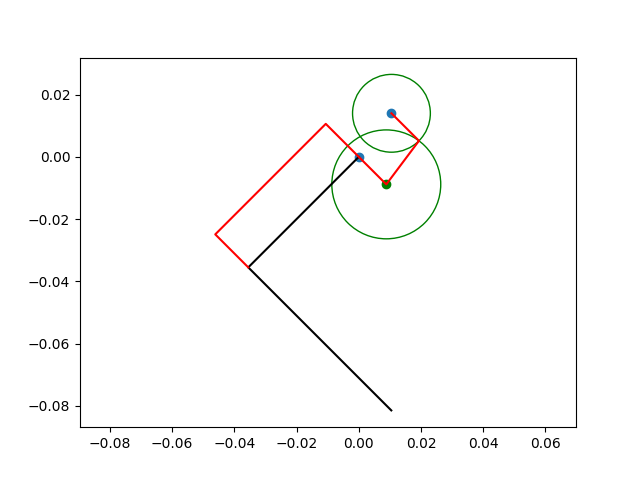

In [7]:
#plot
fig, ax = plt.subplots()
plt.plot(leg[0], leg[1],'-k')
plt.scatter(servos[0], servos[1])
plt.plot(linkage[0], linkage[1],'-r')
plt.scatter(linkage[0,-3], linkage[1, -3], color='green')
circle1 = plt.Circle(linkage[:, 3], servo_link_length, color='g', fill=False)
circle2 = plt.Circle(servos[:, 1], servo_arm_length, color='g', fill=False)
ax.add_patch(circle1)
ax.add_patch(circle2)
plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=False, which='major')

In [8]:
# angle of servo arm (see below)
alpha = -np.arccos((linkage[0, 4] - servos[0, 1])/servo_arm_length)
print("%.5f %.5f" % (np.degrees(alpha), np.degrees(theta + gamma)))

-45.00000 -45.00000


## Special case: Parallelogram

The above considerations are generic and by changing the length of the different part you can see the impact. At first I have taken a wrong measurement which lead me down this path.

However there is a special case where the length of servo_link is exactly the distance between the two servo motors. This is when the following condition is met:

$$ servo\_link\_length^2 = servo\_delta\_x^2 + servo\_delta\_y^2 $$

In this case we have a <a href="https://en.wikipedia.org/wiki/Parallelogram" target="_blank">parallelogram</a> between the lower leg servo and the linkage that revolves around the upper leg servo. There is a second parallelogram formed by the linkage spanning the part revolving around the upper leg servo and the lower leg. An element of that part is adjustable to ensure the property is met.

In this special case the lower leg servo arm is always parallel to the lower leg. We set $\zeta = \theta + \gamma $ as the angle of the lower leg servo arm. We can see that we have a dependency between the position of the upper and lower leg. Changing the position of the upper leg by maintaining the relative position of the lower leg requires also to adapt the lower leg. This is different from quadrupeds where the lower leg actuator is actually attached to the upper leg

## Angle limits

The lower leg servo arm is limited in rotation. First the servo motor itself has a limited rotation of $180^{\circ}$ This is further limited by mechanics. We will have a collision if the lower leg servo arm comes to close to the upper leg servo. We will set a limit of $-90^{\circ}$ We also do not want the end of the upper leg to touch ground before the lower get can get the the ground. We therefore limit the lower leg servo arm to $0^{\circ}$ If the upper leg is set to $-90^{\circ}$ we can not move the lower leg less then $45^{\circ}$

We further limit the upper leg movement to a range between $-90^{\circ}$ and $-180^{\circ}$ and the lower leg movement to a range between $0^{\circ}$ and $135^{\circ}$

In summary and $\zeta = \theta + \gamma $ as the angle of the lower leg servo arm:

$$ -90^{\circ} \leq \zeta \leq 0^{\circ} $$

$$ -180^{\circ} \leq \theta -90^{\circ} $$

$$ 45^{\circ} \leq \gamma \leq 135^{\circ} $$

In [9]:
joints = ['hip', 'upper_leg', 'lower_leg']
legs = ['lf', 'rf', 'lh', 'rh']

angles = np.linspace(-np.pi/2, -np.pi, 20)

for joint in joints:
    for leg in legs:
        with open("../controller/servos/leg-test/%s_%s" % (leg, joint), "w") as f:
            angle = 0.0
            if 'upper' in joint:
                angle = -3*np.pi/4
            if 'lower' in joint:
                angle = np.pi/2
            f.write("%.10f\n" % angle)
  
with open("../controller/servos/leg-test/rf_upper_leg", "w") as f:
    for i in range(len(angles)):
        f.write("%.10f\n" % angles[i])
with open("../controller/servos/leg-test/rf_lower_leg", "w") as f:
    for i in range(len(angles)):
        if angles[i] > -3*np.pi/4:
            f.write("%.10f\n" % (np.pi/2))
        else:
            f.write("%.10f\n" % (3*np.pi/4))
    

In [10]:
for joint in joints:
    for leg in legs:
        with open("../controller/servos/lift-leg/%s_%s" % (leg, joint), "w") as f:
            angle = 0.0
            if 'upper' in joint:
                angle = -3*np.pi/4
            if 'lower' in joint:
                angle = np.pi/2
            f.write("%.10f\n" % angle)
            
with open("../controller/servos/lift-leg/rf_upper_leg", "w") as f:
    angle = -np.pi
    f.write("%.10f\n" % angle)
    
with open("../controller/servos/lift-leg/rf_lower_leg", "w") as f:
    angle = 3*np.pi/4
    f.write("%.10f\n" % angle)